# ERT inversion - beyond the standard

Here, we exemplify the possibilities of pyGIMLi by treating an ERT timelapse data set. Most of the strategies are independent on the method and can be used for other types of data.

The data set here was published by Hübner et al. (2017) and describes a shallow infiltration experiment using a surface electrode layout.


In [221]:
# We import some basic libraries like numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [222]:
# Furthermore we import pygimli and two of its modules
import pygimli as pg
from pygimli.physics import ert
import pygimli.meshtools as mt
from pygimli.viewer import pv

From the whole timelapse set of data files we load a single one, show its properties.

In [223]:
data = ert.load("020.dat")
print(data)

Data: Sensors: 392 data: 2849, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


The data contains 2849 data using 392 electrodes. In the data container, there are the A-B-M-N numbers of the electrodes and resistances (`'r'`). We first plot the electrode positions.

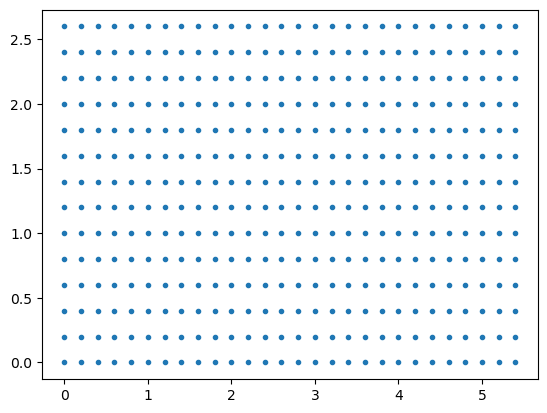

In [224]:
plt.plot(pg.x(data), pg.y(data), ".")

We first compute geometric factors and apparent resistivities and store both in the data container.

In [225]:
data["k"] = ert.geometricFactors(data)
data["rhoa"] = data["r"] * data["k"]

The data exhibit mostly dipole-dipole data measured with a 12-channel ABEM Terrameter LS2 instrument. To fill up the channels, some multi-gradient and some square arrays have been added. We can have a look at the data by using `data.show()` (`ert.show(data)`). 

17/03/24 - 07:54:18 - pyGIMLi - INFO - found 245 x values
17/03/24 - 07:54:18 - pyGIMLi - INFO - found 143 y values
17/03/24 - 07:54:18 - pyGIMLi - INFO - x vector length: 2849
17/03/24 - 07:54:18 - pyGIMLi - INFO - y vector length: 2849
17/03/24 - 07:54:18 - pyGIMLi - INFO - v vector length: 2849
17/03/24 - 07:54:18 - pyGIMLi - INFO - 1390 data of 2849 not shown


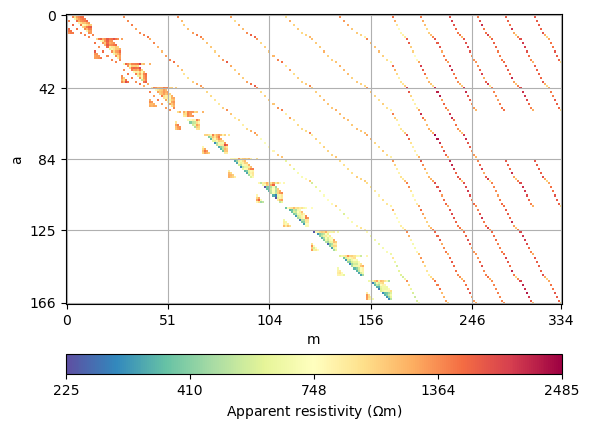

In [226]:
data.show(style="A-M");

We can already see the pseudosections on the main diagonal with some reciprocals mirrored at the diagonal, plus some measurements between the lines (off-diagonals).

In [227]:
# check reciprocals
iFwd, iBwd = ert.reciprocalIndices(data)
print(len(iFwd), len(iBwd))

1943 1943


We have a very limited amount of reciprocal data pairs with which we can do a reciprocal analysis.

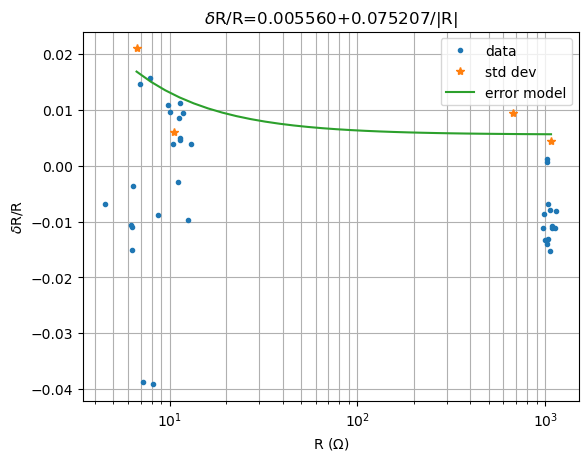

In [228]:
ert.fitReciprocalErrorModel(data, show=True, rel=True);

The number is not large enough and the distribution of R bimodal (DD vs. MG array). For an example with more rigorous data and background of normal-reciprocal analysis see
https://dev.pygimli.org/_examples_auto/3_ert/plot_10_reciprocal_analysis.html 

In order to account for other error sources like electrode positions,
we add 1% and estimate a data error using 2% and 70mOhm (no influence).

In [229]:
data.estimateError(relativeError=0.02, absoluteError=0.07)
print(min(data["err"]), max(data["err"]))
# data.show("err", style="A-M")

0.020027533256240217 0.02046348407601139


We extract a single profile from the data.

Data: Sensors: 14 data: 71, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid']
Detecting small distances, using mm accuracy


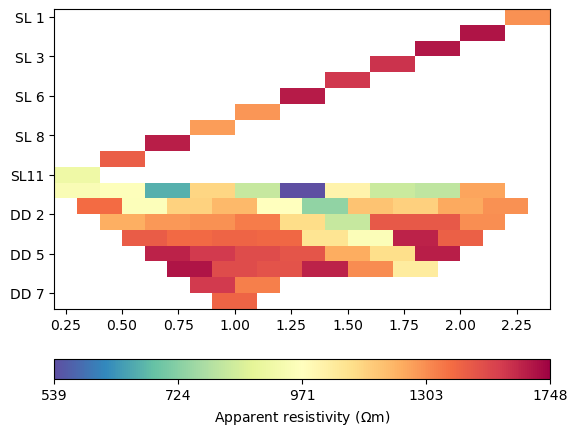

In [230]:
x0 = data.subset(x=0)
print(x0)
x0.setSensors(np.column_stack([pg.y(x0), pg.x(x0)])) # auto for x/y
ax, cb = x0.show()

The upper part is a single multi-gradient using the outermost electrodes, the lower a dipole-dipole section. If we think.

Detecting small distances, using mm accuracy


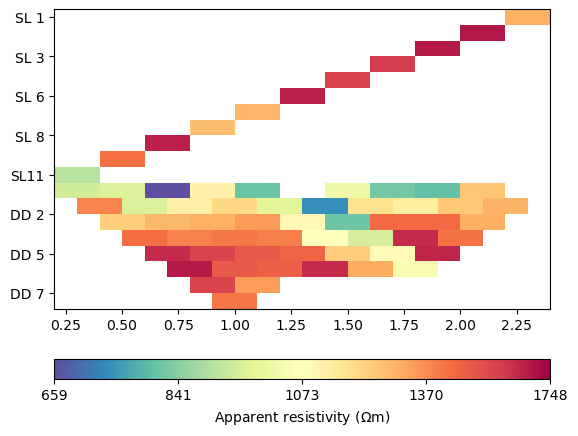

In [231]:
x0.remove(x0["rhoa"] < 600)
ax, cb = x0.show()

In [232]:
mgr = ert.Manager(x0)
mgr.invert(verbose=True)

17/03/24 - 07:54:19 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 07:54:19 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 07:54:19 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 07:54:19 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 07:54:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/03/24 - 07:54:19 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/03/24 - 07:54:19 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
17/03/24 - 07:54:19 - pyGIMLi - INFO - Use median(data values)=1340.4949999999994
17/03/24 - 07:54:19 - pyGIMLi - INFO - Created startmodel from forward operator: 186, min/max=1340.495000/1340.495000
17/03/24 - 07:54:19 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001F49E1C8F90>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001F49E1C8DB0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001F49E1C8D10>
min/max (data): 659/1748
min/max (error): 2%/2.01%
min/max (start model): 1340/1340
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  135.77
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   17.23 (dPhi = 85.90%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.71 (dPhi = 74.48%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.65 (dPhi = 1.79%) lam: 20.0
################################################################################
#                Abort criterion reached: dPhi = 1.79 (< 2.0%)         

186 [859.2916708383892,...,1921.7380982499417]

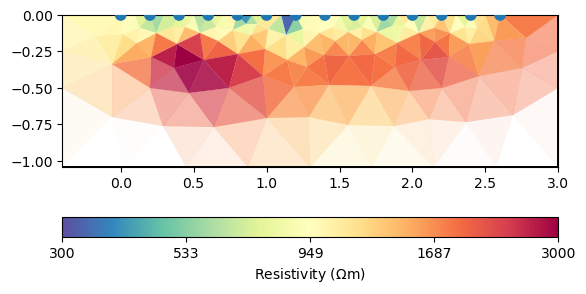

In [233]:
# We show the result using a predefined color-scale
kw = dict(cMin=300, cMax=3000, cMap="Spectral_r", logScale=True)#,
        #   xlabel="x (m)", ylabel="z (m)")
ax, cb = mgr.showResult(**kw)
# we can further modify the figure using the axis and colorbar handles

Now we bring the 2D result into 3D by changing the dimension,
switching y (depth) and z coordinates and finally x and y
(constant) coordinates.

In [234]:
x0result = mgr.paraDomain
x0result["res"] = mgr.model
x0result.setDimension(3)
x0result.swapCoordinates(1, 2)
x0result.swapCoordinates(0, 1)

Data: Sensors: 14 data: 139, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid', 'ya', 'yb', 'ym', 'yn']
Detecting small distances, using mm accuracy


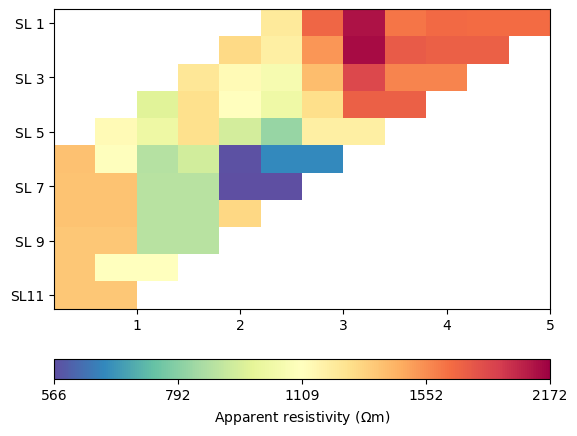

In [235]:
y1 = data.subset(y=0.6)
y1.setSensors(y1.sensors() * np.array([1, 0, 0]))  # auto
print(y1)
y1.show();

17/03/24 - 07:54:20 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 07:54:20 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 07:54:20 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 07:54:20 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 07:54:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/03/24 - 07:54:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/03/24 - 07:54:20 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
17/03/24 - 07:54:20 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
17/03/24 - 07:54:20 - pyGIMLi - INFO - Created startmodel from forward operator: 186, min/max=1227.930000/1227.930000
17/03/24 - 07:54:20 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001F49E747540>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001F49E7475E0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001F49E7422E0>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  194.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   10.28 (dPhi = 94.56%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.69 (dPhi = 89.31%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.69)                   #
################################################################################


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1f49f787550>)

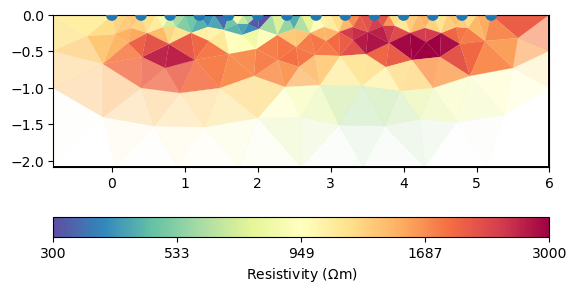

In [236]:
mgr = ert.Manager(y1)
mgr.invert(zWeight=0.3, verbose=True)
ax, cb = mgr.showResult(**kw)

We now want to improve the mesh a bit, step by step, introducing
a smaller boundary, a smaller surface discretization `paraDX`, a
smaller depth, an improved quality and a maximum cell size.

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1f4a3a1dd90>)

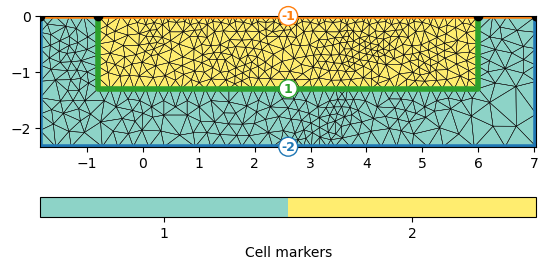

In [247]:
plc = mt.createParaMeshPLC(y1, paraDX=0.25, paraDepth=1.3, 
                           boundary=0.2, paraMaxCellSize=0.03)
mesh = mt.createMesh(plc, quality=34.4)
pg.show(mesh, markers=True, showMesh=True)

17/03/24 - 08:00:52 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 08:00:52 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 08:00:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/03/24 - 08:00:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/03/24 - 08:00:52 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2367 Cells: 4536 Boundaries: 3500
17/03/24 - 08:00:52 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
17/03/24 - 08:00:52 - pyGIMLi - INFO - Created startmodel from forward operator: 699, min/max=1227.930000/1227.930000
17/03/24 - 08:00:52 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001F49E747540>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001F49E7475E0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001F4A239F220>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  194.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   12.04 (dPhi = 93.30%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.32 (dPhi = 80.96%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.94 (dPhi = 9.72%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1f4a3d9b970>)

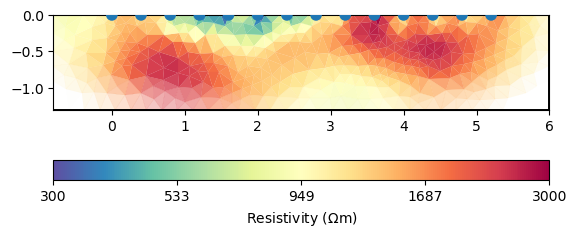

In [248]:
mgr.setMesh(mesh)
mgr.invert(verbose=True)
mgr.showResult(**kw)

17/03/24 - 08:01:40 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
17/03/24 - 08:01:40 - pyGIMLi - INFO - Created startmodel from forward operator: 699, min/max=1227.930000/1227.930000
17/03/24 - 08:01:40 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001F49E747540>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001F49E7475E0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001F49F9DC760>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  194.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   30.78 (dPhi = 84.02%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.57 (dPhi = 93.70%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.77 (dPhi = 38.56%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² 

17/03/24 - 08:01:42 - asyncio - ERROR - Task exception was never retrieved
future: <Task finished name='Task-909' coro=<RequestHandler.start() done, defined at c:\Program Files\software\Anaconda\envs\pg15\lib\site-packages\aiohttp\web_protocol.py:481> exception=AssertionError()>
Traceback (most recent call last):
  File "c:\Program Files\software\Anaconda\envs\pg15\lib\asyncio\tasks.py", line 256, in __step
    result = coro.send(None)
  File "c:\Program Files\software\Anaconda\envs\pg15\lib\site-packages\aiohttp\web_protocol.py", line 524, in start
    request = self._request_factory(message, payload, self, writer, handler)
  File "c:\Program Files\software\Anaconda\envs\pg15\lib\site-packages\aiohttp\web_app.py", line 485, in _make_request
    return _cls(
  File "c:\Program Files\software\Anaconda\envs\pg15\lib\site-packages\aiohttp\web_request.py", line 825, in __init__
    super().__init__(*args, **kwargs)
  File "c:\Program Files\software\Anaconda\envs\pg15\lib\site-packages\aioh

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1f4a4166b80>)

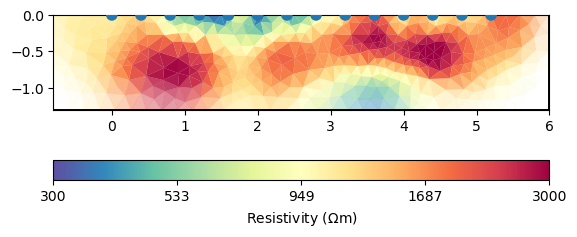

In [249]:
mgr.inv.setRegularization(cType=2)
mgr.invert(verbose=True)
mgr.showResult(**kw)

17/03/24 - 08:06:15 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
17/03/24 - 08:06:15 - pyGIMLi - INFO - Created startmodel from forward operator: 699, min/max=1227.930000/1227.930000
17/03/24 - 08:06:15 - pyGIMLi - INFO - Starting inversion.
17/03/24 - 08:06:15 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 2 with: I=[1, 0.1], dip=0, strike=0


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001F49E747540>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001F49E7475E0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001F4A3D40FA0>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------


17/03/24 - 08:06:15 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 0.3s
17/03/24 - 08:06:15 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\6780675307155642634


inv.iter 0 ... chi² =  194.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   42.06 (dPhi = 78.10%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    5.54 (dPhi = 85.49%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.70 (dPhi = 43.85%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.00 (dPhi = 45.25%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (1.00)                   #
################################################################################


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1f49e450880>)

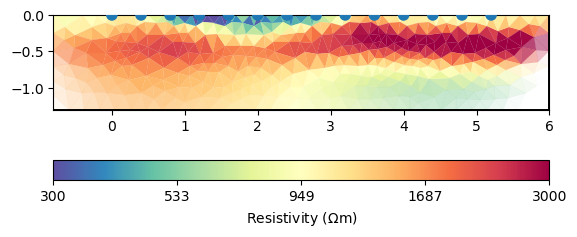

In [250]:
mgr.inv.setRegularization(correlationLengths=[1, 0.1])
mgr.invert(verbose=True)
mgr.showResult(**kw)

We bring the 2d result into 3D

In [237]:
y1result = mgr.paraDomain
y1result["res"] = mgr.model
y1result.setDimension(3)
y1result.swapCoordinates(1, 2)
y1result.translate([0, 0.6, 0])
y1result.boundingBox()
# pg.show(y1result, "res", **kw)

BoundingBox [RVector3: (-0.7999999999999999, 0.6, -2.08), RVector3: (6.0, 0.6, 0.0)]

In [238]:
kw = dict(cMin=300, cMax=3000, logScale=True, cMap="Spectral_r")
pl, _ = pg.show(x0result, "res", **kw, hold=True)
pv.drawMesh(pl, y1result, label="res", **kw)
pl.show()

Widget(value='<iframe src="http://localhost:56152/index.html?ui=P_0x1f49f9e04f0_36&reconnect=auto" class="pyvi…

In [239]:
plc = mt.createParaMeshPLC3D(data)
mesh = mt.createMesh(plc, quality=1.3)
print(mesh)
pg.show(mesh, style="wireframe")

Mesh: Nodes: 1762 Cells: 7984 Boundaries: 16854


Widget(value='<iframe src="http://localhost:56152/index.html?ui=P_0x1f49f9e0700_37&reconnect=auto" class="pyvi…

(<pyvista.plotting.plotter.Plotter at 0x1f49f9e0700>, None)

In [240]:
mgr3d = ert.Manager(data)
mgr3d.setMesh(mesh)
mgr3d.invert(verbose=True)

17/03/24 - 07:54:23 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 07:54:23 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 07:54:23 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/03/24 - 07:54:23 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/03/24 - 07:54:24 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 12393 Cells: 63872 Boundaries: 67416
17/03/24 - 07:54:24 - pyGIMLi - INFO - Use median(data values)=1126.759999999999
17/03/24 - 07:54:24 - pyGIMLi - INFO - Created startmodel from forward operator: 4018, min/max=1126.760000/1126.760000
17/03/24 - 07:54:24 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001F49FB32E00>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001F49FB32F40>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001F49FB32EA0>
min/max (data): 151/2542
min/max (error): 2%/2.05%
min/max (start model): 1127/1127
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  337.21
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   24.10 (dPhi = 92.08%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   11.38 (dPhi = 46.09%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.84 (dPhi = 35.72%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    4.36 (dPhi = 14.37%) lam: 20.0
--------------

4018 [1144.6635574526742,...,551.5455955233703]

In [241]:
result3d = mgr3d.paraDomain
result3d["res"] = mgr3d.paraModel()
# pg.show(result3d, "res", **kw);
pl, _ = pg.show(result3d, label="res", style="surface", hold=True, **kw,
                filter={"threshold": dict(value=500, scalars="res", method="lower")})
pv.drawMesh(pl, result3d, label="res", style="surface", **kw,
            filter={"slice": dict(normal="y", origin=[0, 1, 0])})
pl.show()

Widget(value='<iframe src="http://localhost:56152/index.html?ui=P_0x1f49f958490_38&reconnect=auto" class="pyvi…

## Timelapse inversion

For this data set, we have a lot of data over a couple of days.
Of course, we could invert these step by step and compare the
individual models (SHOULD WE DO THAT HERE?).
For timelapse ERT, there is a specialized class `TimelapseERT`.
It handles the data, e.g. filtering and masking, but also 
exhibits several timelapse strategies, such as 4D inversion.

For more details, see the example on
https://www.pygimli.org/_examples_auto/3_ert/plot_09_ert_timelapse.html

In [252]:
tl = ert.TimelapseERT("*.dat")
print(tl)

17/03/24 - 08:11:15 - pyGIMLi - INFO - Cache c:\Guenther.T\src\gimli\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 1): C:\Guenther.T\Anwendungsdaten\pygimli\Cache\15129487419898899544


Timelapse ERT data:
Data: Sensors: 392 data: 972, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']
7 time steps from 2024-03-17 08:11 to 2024-03-23 08:11


(array([0.68752327, 0.20776151, 0.18058016, 0.31989094, 0.23673541,
        0.28763426, 0.23571159]),
 array([0.00978302, 0.00442956, 0.00533587, 0.00510618, 0.00547779,
        0.00511538, 0.00545342]))

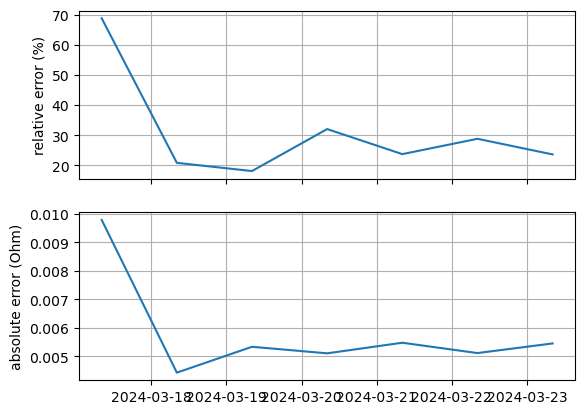

In [253]:
tl.fitReciprocalErrorModel(show=True)

In [ ]:
tl.fullInversion()

## References
* Hübner, R., Günther, T., Heller, K., Noell, U. & Kleber, A. (2017): Impacts of a capillary barrier on infiltration and subsurface stormflow in layered slope deposits monitored with 3-D ERT and hydrometric measurements. Hydrol. Earth Syst. Sci. 21, 5181-5199, doi:10.5194/hess-21-5181-2017.
